#### Optuna for settings (hyperparameters - actor critic)

In [ ]:
import random; random.seed(0)
import numpy as np; np.random.seed(0)
from utils_bandits import train_agent

settings = {'episode_length': 1000,
            'episodes': 5000,
            'gamma': 0.99,
            'decay_rate': .99899,#0.98,
            'buffer_size': 256,
            'lr_actor': 0.0011333554636375582,
			'temperature': .2446,
			'final_temperature': 0.01}

average_reward, deviation_reward, history = train_agent(settings, 
                                                        use_mlflow = False, 
														output_path = 'outputs',
              												save_suffix = "_best_exp",
                                                            use_rnn=True)

In [ ]:
import pickle
from matplotlib import pyplot as plt
from glob import glob

from Concept_Mining.models.SimulationEnvironment import explore_environment
from Concept_Mining.models.ContextualBandit import AdaptationEngine
from Concept_Mining.utils.settings import  pretraining_settings as settings
from tqdm import tqdm
import torch
import numpy as np

def get_entropy(preferences):
	return -torch.sum(preferences * torch.log(preferences), dim = -1)

with open("clip_encodings.pkl", "rb") as f:
	data = pickle.load(f)
	image_encodings = data['image_encodings']
	actions_encode = data['concept_encodings']

with open("generated_concepts.pkl", "rb") as f:
	data = pickle.load(f)
	generated_concepts = data['concepts']
	topic_groups = data['topic_groups']

with open('encodings.pkl', 'rb') as f:
	captions = pickle.load(f)['captions']

images = [i for i in glob("../dataset/Images/*.jpg")]

Agent = AdaptationEngine(state_dim = image_encodings.shape[1] + actions_encode.shape[1],
						 	action_dim=actions_encode.shape[1],
							action_space_len=actions_encode.shape[0],
							lr_actor = settings.lr_actor,
							lr_critic = settings.lr_critic,
							gamma = settings.gamma,
							buffer_size = settings.buffer_size,
							sample_temperature = settings.temperature,
							final_temperature = settings.final_temperature,
							temperature_decay = settings.decay_rate)

def get_trajectory( env_snapshot, state, trajectory_len: int = 10 ):
	
	current_path = []
	processed_state = env_snapshot.preprocess_state(state)

	for _ in range(trajectory_len):
		
		preferences = Agent.policy(processed_state, actions_encode)
		action = preferences.argmax() #torch.multinomial(preferences, 1).squeeze(-1)
		
		current_path.append(action.item())
		processed_state = env_snapshot.preprocess_state(state, current_path=current_path)
	
	return current_path

env = explore_environment(topic_groups=topic_groups, 
						  concepts=generated_concepts,
						  concepts_encode=actions_encode,
						  images=images,
						  images_caption=captions,
						  images_encode=image_encodings, 
						  threshold=10)


Agent.Actor.load('bandit_best.pt')
Agent.eval()
# Agent.Critic.load('critic_best.pt')
prediction = []
remaining = []

taken_actions = []

with torch.no_grad():
	for episode in range(1):

		episode_index, (prev_state, feedback, _) = env.reset()
		prev_state = env.preprocess_state(prev_state)

		env.externalized.add(feedback)
				
		itera = tqdm(range(len(env.topic)))
		itera.set_description(f"Episode {episode}")

		for step in itera:

			# actions_trajectory = get_trajectory(env, prev_state, trajectory_len = 10)

			# prediction.append(actions_trajectory.copy())
			# remaining.append(env.topic[env.step_index:].copy())
			preferences = Agent.policy(prev_state, actions_encode).cpu()[0]
			preferences[taken_actions] = -1<<32
			action = preferences.argmax() #torch.multinomial(preferences, 1).squeeze(-1)

			state, feedback, _, done = env.step( action )
			taken_actions.append(action.item())
			print(action.item(), generated_concepts[action.item()])
			state = env.preprocess_state(state)
			# state, feedback, _, done = env.step( actions_trajectory[0] )
			env.externalized.add(feedback)
			# actions_trajectory = state
			prev_state = state

			if done:
				break		

Episode 0:   0%|          | 0/20 [00:00<?, ?it/s]


AttributeError: 'tuple' object has no attribute 'to'

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.manifold import TSNE

np.random.seed(42)
embeddings_1 = actions_encode[env.topic]

embeddings_2 = actions_encode[taken_actions] 
Set1 = ["Externalized"]*len(embeddings_1) 
Set2 = ["Proposed"]*len(embeddings_2)  # Labels for second set

labels_1 = [generated_concepts[i] for i in env.topic] 
labels_2 = [generated_concepts[i] for i in taken_actions] # Labels for second set

# Concatenate embeddings
embeddings = np.vstack([embeddings_1, embeddings_2])
labels = labels_1 + labels_2  # Merge labels
Sets = Set1 + Set2

# Dimensionality Reduction (Use TSNE or UMAP)
reducer = TSNE(n_components=2, perplexity=5, random_state=42)
reduced_embeddings = reducer.fit_transform(embeddings)

# Create DataFrame
df = pd.DataFrame(reduced_embeddings, columns=["x", "y"])
df["Set"] = Sets  # Assign label to distinguish sets
df["Label"] = labels  # Assign label for hover


# Custom color mapping (Red for Set 1, Blue for Set 2)
color_map = {"Set 1": "red", "Set 2": "blue"}

# Interactive Plot
fig = px.scatter(df, x="x", y="y", color="Set", hover_data=["Label"], title="Comparison of Two Embedding Sets",
                 color_discrete_map=color_map, size_max=30)
fig.show()

/workspaces/jde/Concept_Mining/models/ContextualBandit.py:102: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path, map_location=self.device))

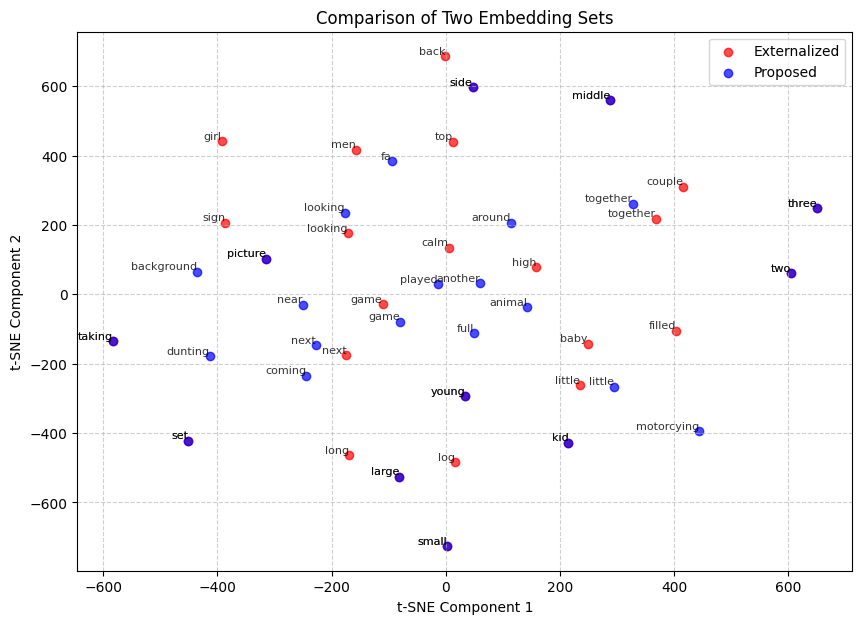

Ground Truth: filled,side,kid,men,two,three,set,baby,together,middle,next,small,looking,taking,picture,little,young,high,game,large,top,log,calm,girl,couple,long,sign,back

Proposed: animal,near,side,two,three,set,full,together,middle,next,small,looking,taking,kid,little,young,picture,game,large,coming,background,motorcying,fa,played,another,dunting,around



{'rewards': -5.0,
 'hit_rate': 0.48148148148148145,
 'matching': 0.6184448462929476,
 'kl_divergency': 4.232865973958736}

In [1]:
from utils.utils_bandits import simulate

import pickle
from matplotlib import pyplot as plt
from glob import glob

from models.SimulationEnvironment import explore_environment
from models.ContextualBandit import AdaptationEngine
from utils.settings import  pretraining_settings as settings
from tqdm import tqdm
import torch
import numpy as np

with open("clip_encodings.pkl", "rb") as f:
	data = pickle.load(f)
	image_encodings = data['image_encodings']
	actions_encode = data['concept_encodings']

with open("generated_concepts.pkl", "rb") as f:
	data = pickle.load(f)
	generated_concepts = data['concepts']
	topic_groups = data['topic_groups']

with open('encodings.pkl', 'rb') as f:
	captions = pickle.load(f)['captions']

images = [i for i in glob("../dataset/Images/*.jpg")]

Agent = AdaptationEngine(state_dim = image_encodings.shape[1] + actions_encode.shape[1],
						 	action_dim=actions_encode.shape[1],
							action_space_len=actions_encode.shape[0],
							lr_actor = settings.lr_actor,
							lr_critic = settings.lr_critic,
							gamma = settings.gamma,
							buffer_size = settings.buffer_size,
							sample_temperature = settings.temperature,
							final_temperature = settings.final_temperature,
							temperature_decay = settings.decay_rate, 
							use_rnn = True)

env = explore_environment(topic_groups=topic_groups, 
						  concepts=generated_concepts,
						  concepts_encode=actions_encode,
						  images=images,
						  images_caption=captions,
						  images_encode=image_encodings, 
						  threshold=10)


Agent.Actor.load('outputs/bandit_best.pt')
Agent.eval()

simulate(Agent=Agent, topic_groups=topic_groups,
          generated_concepts=generated_concepts, actions_encode=actions_encode,
            image_encodings=image_encodings, captions=captions, images=images, 
            topic_index=1, save_plot = False, output_path = "outputs")

  0%|          | 0/16 [00:00<?, ?it/s]

Episode 0:  88%|████████▊ | 14/16 [00:01<00:00,  9.29it/s]
[nltk_data] Downloading package wordnet to /app/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


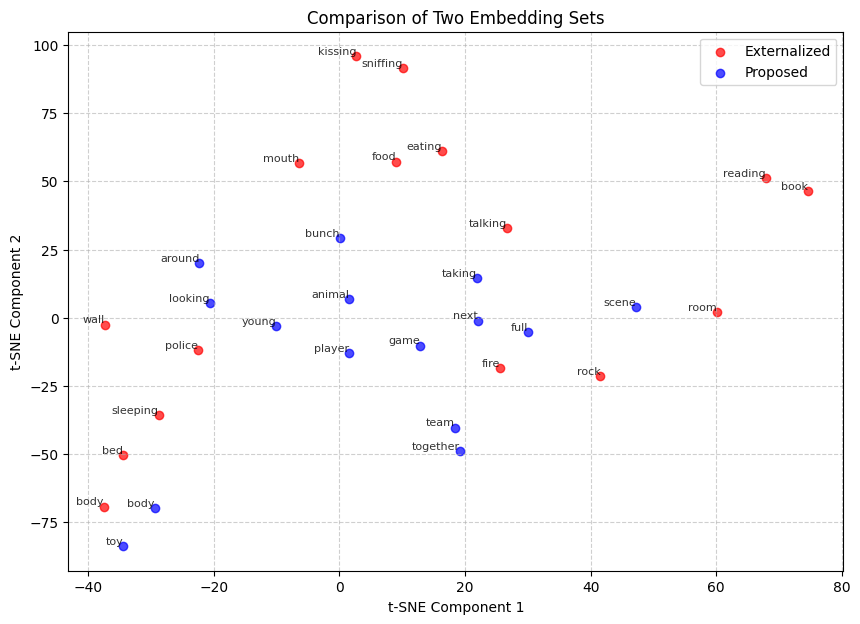

Ground Truth: rock,police,bed,body,wall,reading,food,book,sniffing,eating,talking,fire,kissing,mouth,room,sleeping

Proposed: animal,next,body,toy,player,full,around,team,together,taking,looking,scene,young,bunch,game



Episode 0:  93%|█████████▎| 26/28 [00:02<00:00,  9.83it/s]
[nltk_data] Downloading package wordnet to /app/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


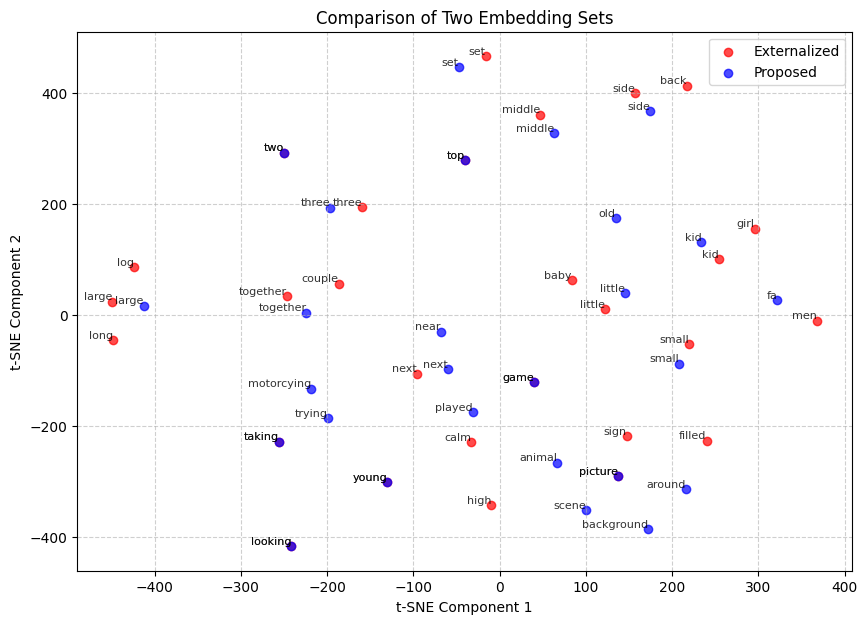

Ground Truth: filled,side,kid,men,set,three,next,small,calm,together,middle,picture,two,looking,baby,game,young,little,top,long,high,large,back,taking,couple,log,sign,girl

Proposed: animal,near,side,set,three,next,small,around,together,scene,middle,two,looking,kid,game,young,picture,top,little,background,large,fa,taking,played,trying,old,motorcying



Episode 0:  83%|████████▎ | 10/12 [00:00<00:00, 13.88it/s]
[nltk_data] Downloading package wordnet to /app/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


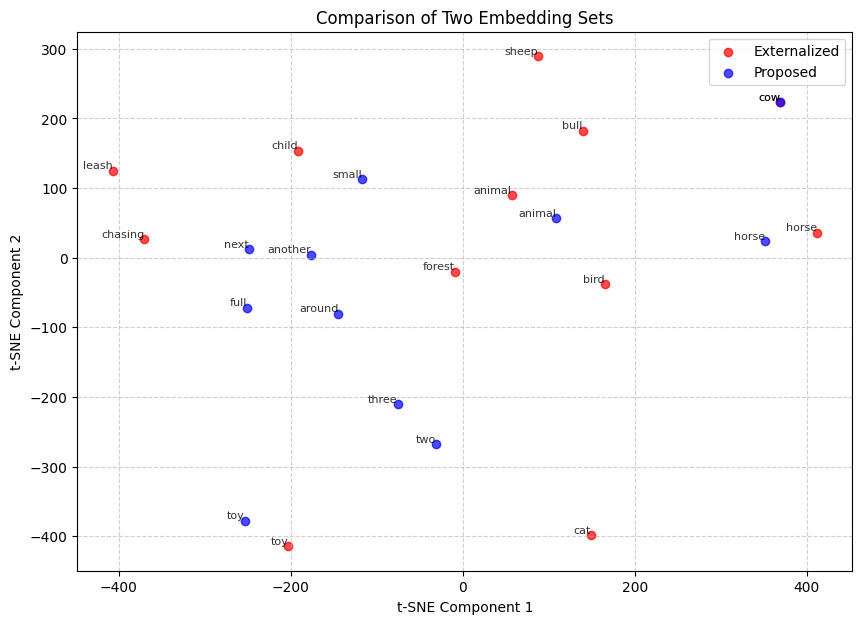

Ground Truth: child,animal,cat,toy,bull,cow,horse,sheep,bird,leash,chasing,forest

Proposed: animal,three,toy,two,another,horse,full,cow,around,small,next



Episode 0:  92%|█████████▏| 22/24 [00:02<00:00, 10.56it/s]
[nltk_data] Downloading package wordnet to /app/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


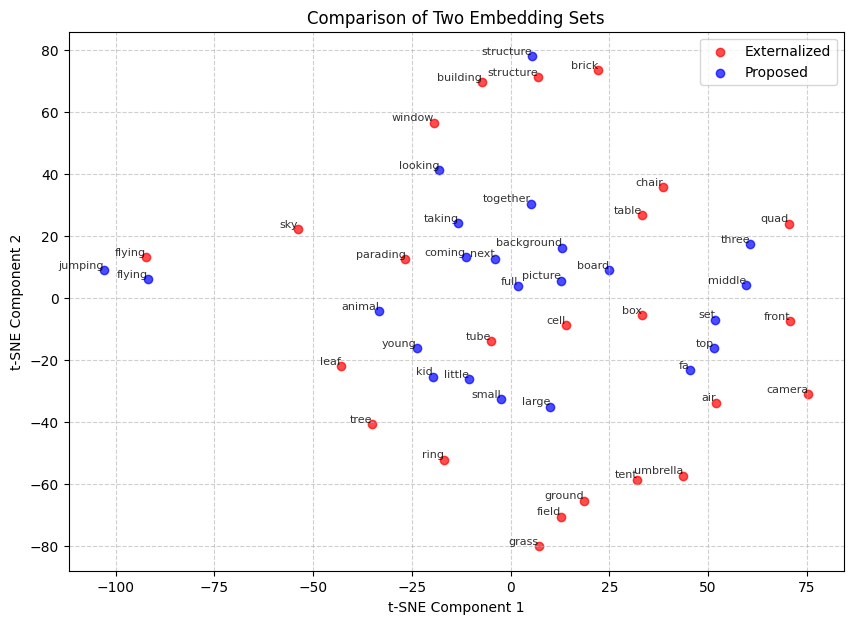

Ground Truth: building,structure,umbrella,flying,air,ring,box,tube,ground,leaf,grass,field,window,camera,tent,chair,front,tree,brick,parading,table,cell,sky,quad

Proposed: structure,three,flying,top,jumping,set,full,animal,together,looking,small,next,coming,kid,middle,taking,young,picture,background,large,fa,little,board



Episode 0:  86%|████████▌ | 12/14 [00:00<00:00, 34.73it/s]
[nltk_data] Downloading package wordnet to /app/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


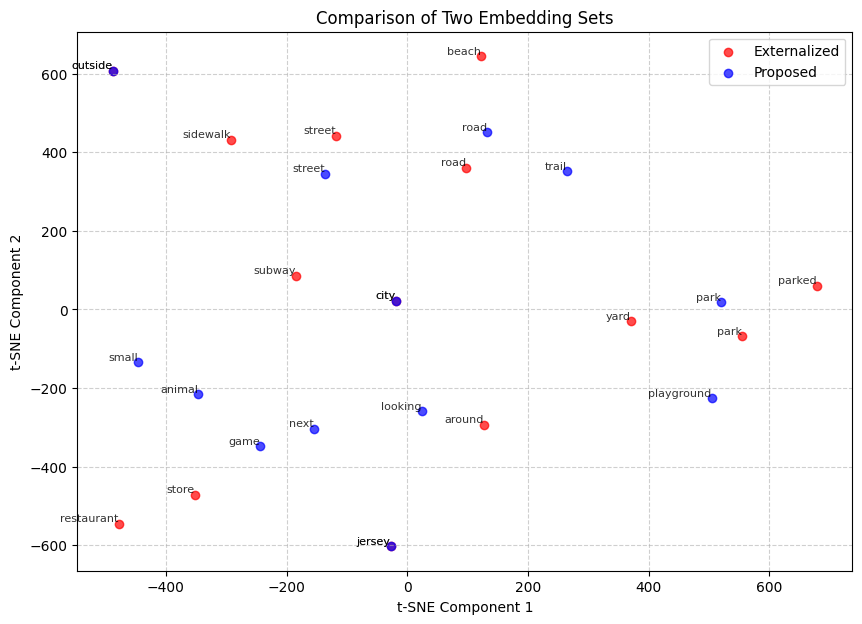

Ground Truth: subway,park,road,street,city,jersey,outside,around,restaurant,parked,store,beach,sidewalk,yard

Proposed: park,road,street,city,jersey,trail,animal,game,outside,next,playground,looking,small



Episode 0:  75%|███████▌  | 6/8 [00:00<00:00, 34.13it/s]
[nltk_data] Downloading package wordnet to /app/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


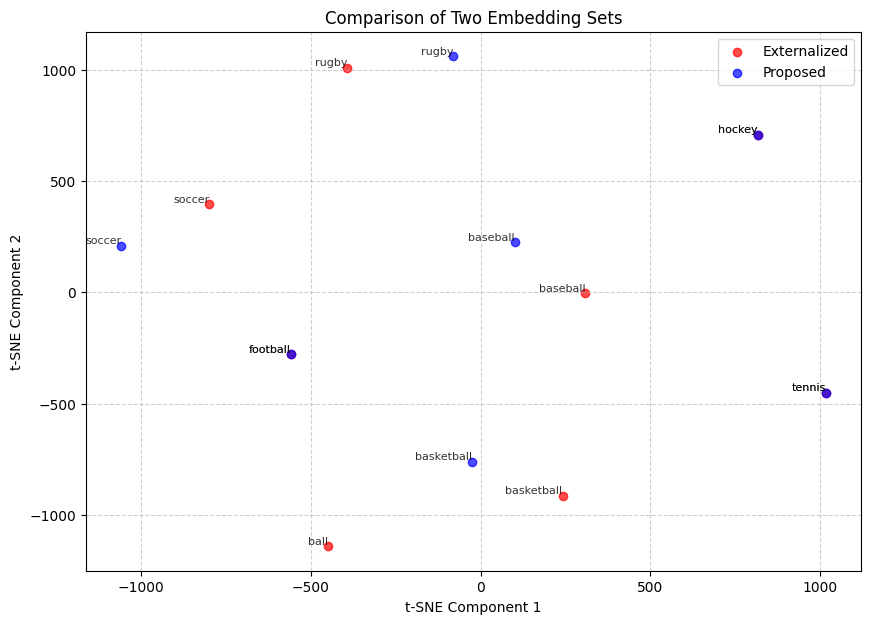

Ground Truth: rugby,baseball,tennis,basketball,hockey,soccer,football,ball

Proposed: baseball,tennis,basketball,hockey,soccer,football,rugby



Episode 0:  90%|█████████ | 18/20 [00:00<00:00, 35.10it/s]
[nltk_data] Downloading package wordnet to /app/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


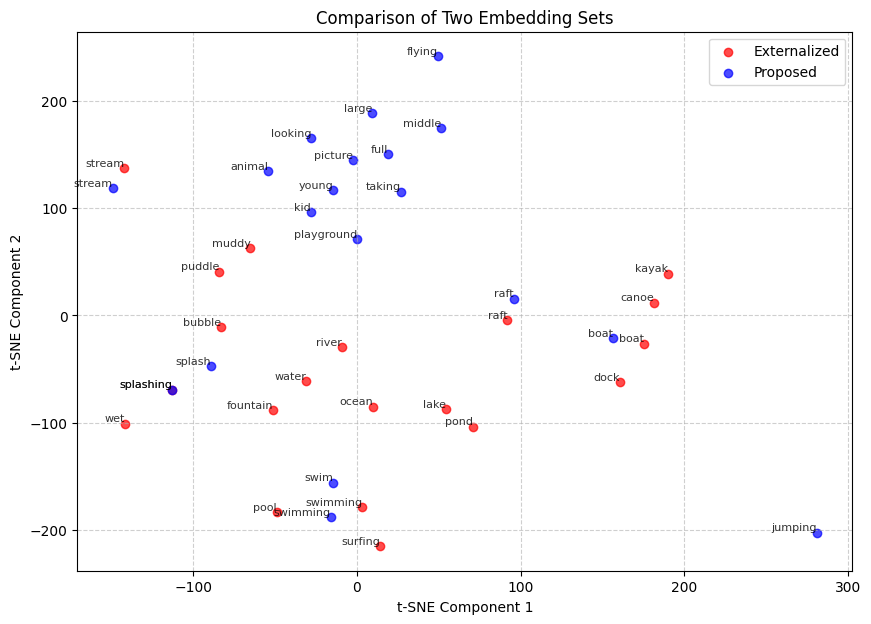

Ground Truth: water,stream,bubble,splashing,surfing,pool,swimming,lake,raft,kayak,fountain,muddy,pond,ocean,river,canoe,boat,dock,puddle,wet

Proposed: stream,animal,splashing,full,picture,swimming,looking,swim,jumping,raft,flying,kid,splash,middle,young,boat,playground,large,taking



Episode 0:  85%|████████▍ | 11/13 [00:00<00:00, 110.33it/s]
[nltk_data] Downloading package wordnet to /app/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


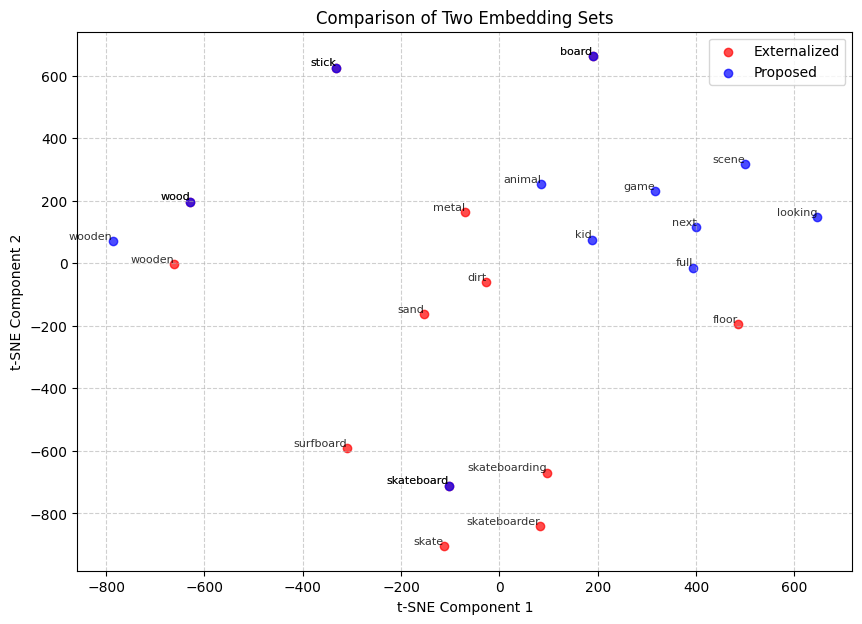

Ground Truth: metal,wood,wooden,stick,sand,board,skateboarder,floor,skate,skateboard,surfboard,dirt,skateboarding

Proposed: animal,wooden,stick,looking,board,next,full,game,kid,skateboard,wood,scene



Episode 0:  89%|████████▉ | 16/18 [00:00<00:00, 116.40it/s]
[nltk_data] Downloading package wordnet to /app/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


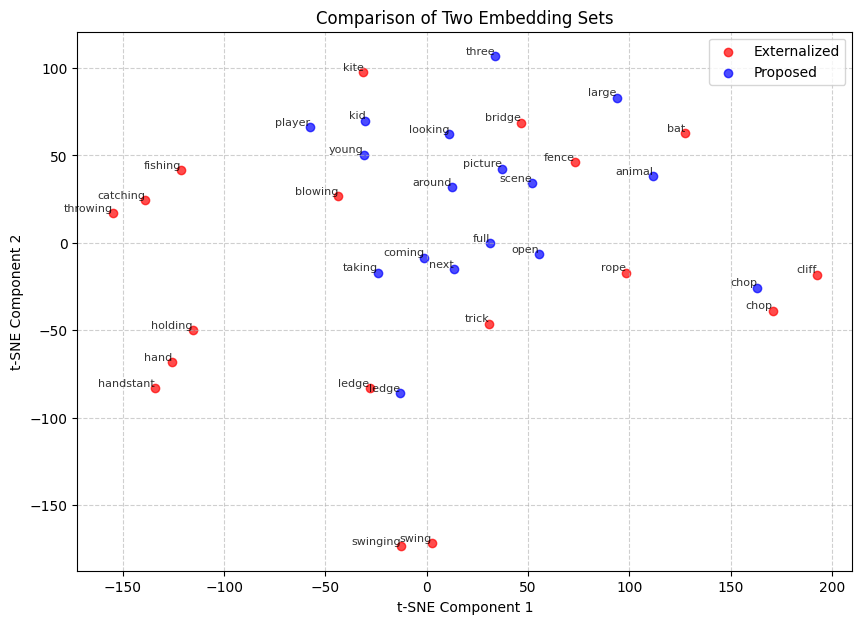

Ground Truth: chop,ledge,catching,blowing,swinging,fence,kite,trick,fishing,rope,bat,cliff,throwing,hand,holding,swing,bridge,handstant

Proposed: animal,open,chop,full,ledge,coming,player,around,next,taking,kid,scene,three,young,looking,picture,large



Episode 0:  87%|████████▋ | 13/15 [00:00<00:00, 129.98it/s]
[nltk_data] Downloading package wordnet to /app/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


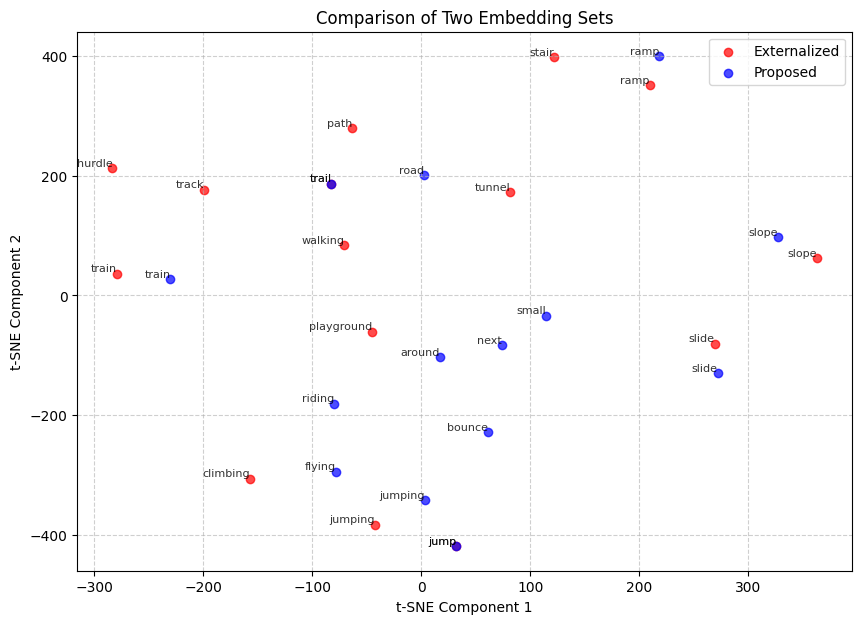

Ground Truth: climbing,ramp,slide,slope,jump,jumping,path,trail,tunnel,walking,playground,stair,track,train,hurdle

Proposed: riding,slide,slope,jump,jumping,next,trail,flying,around,small,road,ramp,bounce,train



Episode 0:  75%|███████▌  | 6/8 [00:00<00:00, 33.23it/s]
[nltk_data] Downloading package wordnet to /app/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


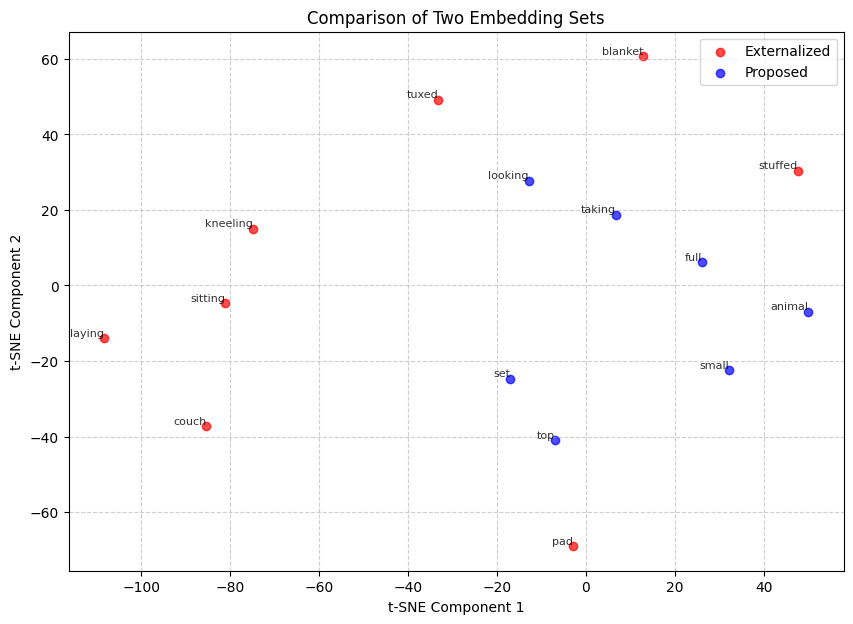

Ground Truth: stuffed,sitting,pad,kneeling,laying,couch,blanket,tuxed

Proposed: animal,set,top,looking,full,small,taking



Episode 0:  87%|████████▋ | 13/15 [00:00<00:00, 299.63it/s]
[nltk_data] Downloading package wordnet to /app/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


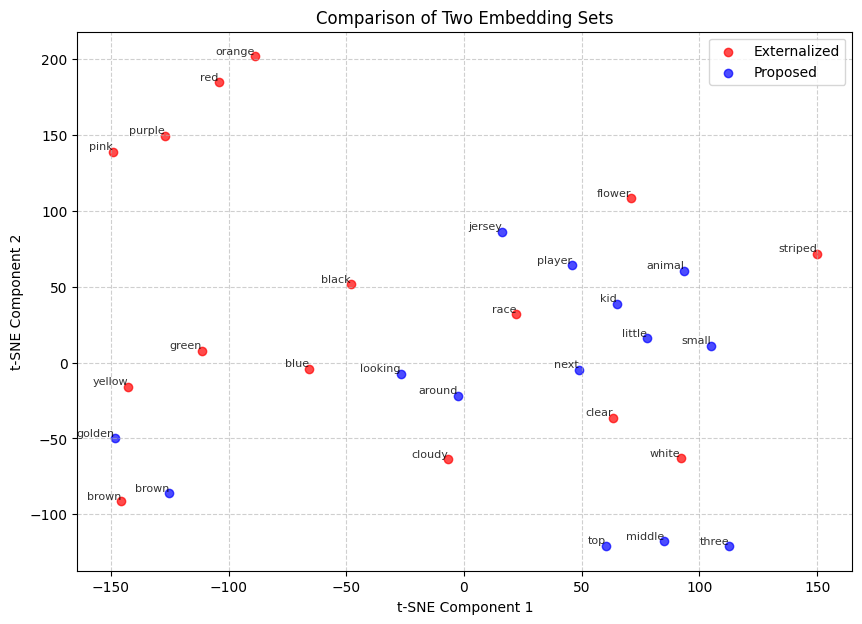

Ground Truth: cloudy,yellow,race,flower,purple,black,brown,orange,clear,white,red,blue,green,striped,pink

Proposed: jersey,golden,animal,three,top,small,player,brown,around,next,looking,kid,middle,little



Episode 0:  75%|███████▌  | 6/8 [00:00<00:00, 31.17it/s]
[nltk_data] Downloading package wordnet to /app/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


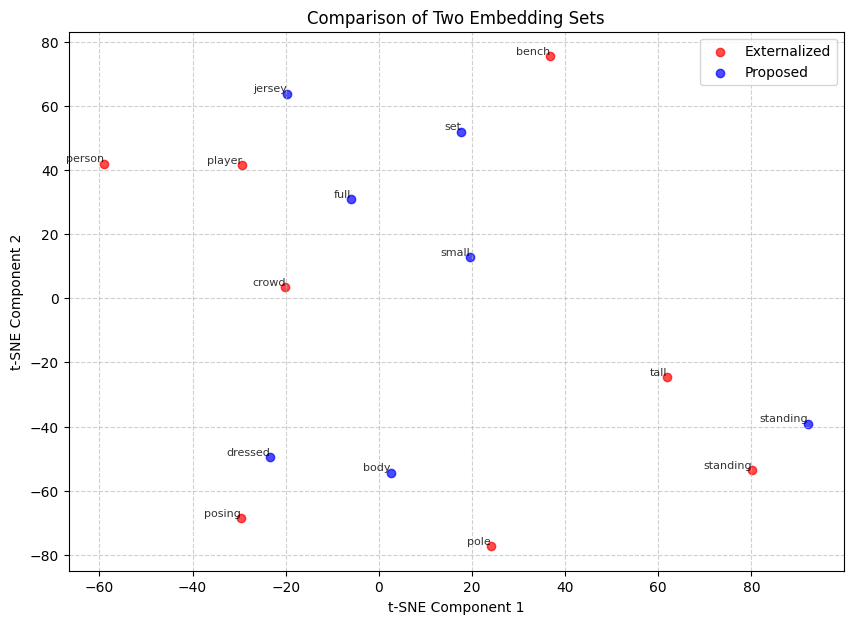

Ground Truth: posing,standing,tall,bench,crowd,player,person,pole

Proposed: standing,dressed,body,small,set,jersey,full



Episode 0:  88%|████████▊ | 14/16 [00:00<00:00, 155.61it/s]
[nltk_data] Downloading package wordnet to /app/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


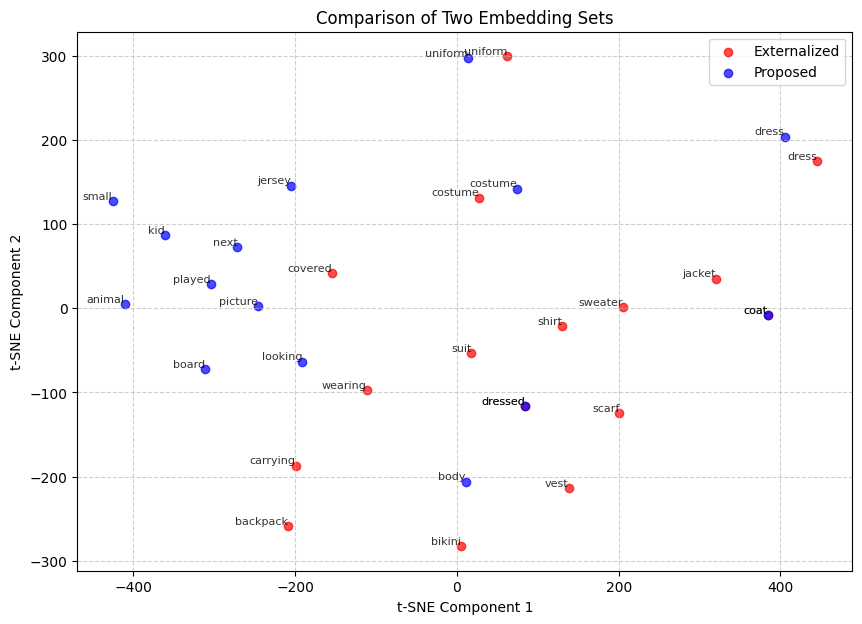

Ground Truth: suit,costume,uniform,bikini,dressed,coat,dress,shirt,covered,wearing,jacket,carrying,sweater,vest,scarf,backpack

Proposed: costume,uniform,board,dressed,jersey,coat,animal,dress,picture,body,kid,small,next,looking,played



Episode 0:  78%|███████▊  | 7/9 [00:00<00:00, 56.89it/s]
[nltk_data] Downloading package wordnet to /app/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


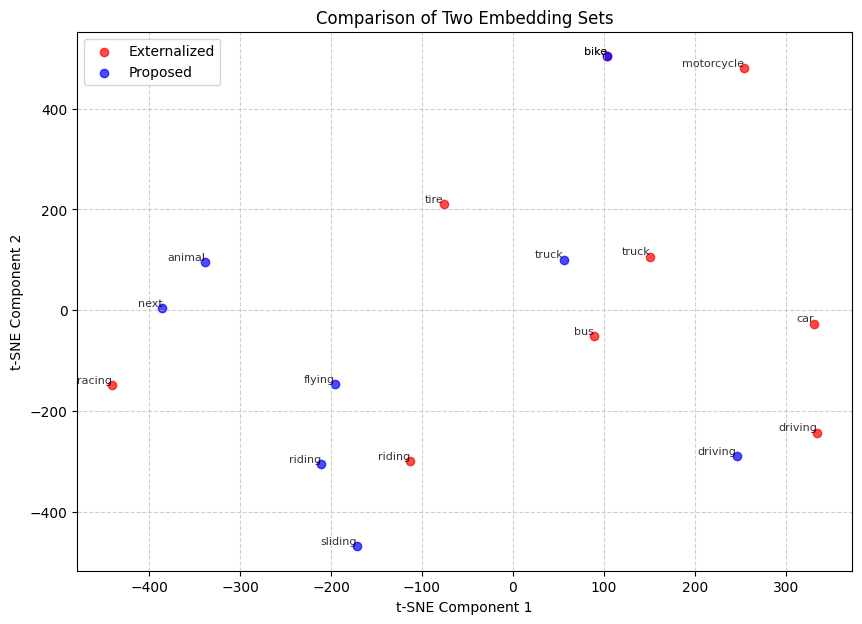

Ground Truth: racing,riding,car,driving,truck,motorcycle,bike,bus,tire

Proposed: riding,sliding,driving,truck,next,bike,animal,flying



In [2]:
h = []

for i in env.topic_groups.keys():
	h += [simulate(Agent=Agent, topic_groups=topic_groups,
			generated_concepts=generated_concepts, actions_encode=actions_encode,
				image_encodings=image_encodings, captions=captions, images=images, 
				topic_index=i, save_plot = False, output_path = "outputs")]

In [3]:
h

[{'rewards': -65.0,
  'hit_rate': 0.06666666666666667,
  'matching': 0.07725321888412018,
  'kl_divergency': 39.2964537536306},
 {'rewards': -15.0,
  'hit_rate': 0.4444444444444444,
  'matching': 0.6763110307414105,
  'kl_divergency': 3.7131692244977907},
 {'rewards': -25.0,
  'hit_rate': 0.2727272727272727,
  'matching': 0.3006134969325153,
  'kl_divergency': 580.8217849114046},
 {'rewards': -95.0,
  'hit_rate': 0.08695652173913043,
  'matching': 0.12091503267973856,
  'kl_divergency': 48.39045272683692},
 {'rewards': -15.0,
  'hit_rate': 0.38461538461538464,
  'matching': 0.3894736842105263,
  'kl_divergency': 77.04412319777475},
 {'rewards': 25.0,
  'hit_rate': 0.8571428571428571,
  'matching': 0.4864864864864865,
  'kl_divergency': 373.3193150748028},
 {'rewards': -55.0,
  'hit_rate': 0.21052631578947367,
  'matching': 0.36666666666666664,
  'kl_divergency': 15.926627790529146},
 {'rewards': -30.0,
  'hit_rate': 0.25,
  'matching': 0.5934959349593496,
  'kl_divergency': 95.14441836

In [6]:
print("Average reward hit rate: ", np.mean([i['hit_rate'] for i in h]))
print("Average reward: ", np.mean([i['rewards'] for i in h]))
print("Average matching: ", np.mean([i['matching'] for i in h]))
print("Average kl divergence: ", np.mean([i['kl_divergency'] for i in h]))

Average reward hit rate:  0.25630053563692007
Average reward:  -36.333333333333336
Average matching:  0.33361825685729746
Average kl divergence:  743.6925006975347


In [9]:
l

[16, 28, 12, 24, 14, 8, 20, 13, 18, 15, 8, 15, 8, 16, 9]

In [11]:
from scipy.stats import pearsonr

corr_xy, p_value = pearsonr(l, [i['hit_rate'] for i in h])
print("Correlation =", corr_xy, "p-value =", p_value)

Correlation = -0.18353011867561667 p-value = 0.5126344639931184
